In [41]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [42]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
!pip install -U duckduckgo-search

In [43]:
from fastbook import *
from fastai.vision.widgets import *
from duckduckgo_search import DDGS
from fastcore.all import *
import time, json
from ipywidgets import widgets
from IPython.display import display

In [44]:
def search_images(keywords, max_images=5): return L(DDGS().images(keywords, max_results=max_images)).itemgot("image")

urls = search_images('grizzly bear', 1)
urls[0]

'https://2.bp.blogspot.com/-NjMTuklENdE/UHzVv_8dIxI/AAAAAAAAA-U/tNBsQDn8kFI/s1600/Grizzly+Bear+Pic.jpg'

In [45]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        urls = search_images(f'{o} bear', 150)
        download_images(dest, urls=urls)

In [46]:
fns = get_image_files(path)
fns

(#395) [Path('bears/grizzly/4c8f428c-0e77-4154-bbff-cb8a7c68c499.jpg'),Path('bears/grizzly/e8f97afe-4c90-43de-b642-a6eda1a3288a.jpg'),Path('bears/grizzly/07b7c406-7cb7-44e5-860a-d05cf7f0f70a.jpg'),Path('bears/grizzly/fba2e5cd-e5ce-418a-ae9c-f67a55b1c5ed.jpg'),Path('bears/grizzly/8566a7be-a671-4b13-b9b0-1edfe8376f46.jpg'),Path('bears/grizzly/a1bb5b2c-77cb-4952-a62c-93d922823083.jpeg'),Path('bears/grizzly/0abc1820-57aa-4432-aa66-875a7134d9d5.jpg'),Path('bears/grizzly/49ef3915-8eff-4461-9ac6-b1696097edd6.jpg'),Path('bears/grizzly/9a334035-916c-475c-a949-2037853490ec.jpg'),Path('bears/grizzly/82235d9b-d8c4-4416-bc93-830e28366bfd.jpg'),Path('bears/grizzly/aa1dfd0b-9e4e-4302-9970-7abaae296260.jpg'),Path('bears/grizzly/8e13d873-1195-4ccc-916a-4e35bab4eaa7.jpg'),Path('bears/grizzly/bf765c45-c57f-4761-9e89-de96239bb4f0.jpg'),Path('bears/grizzly/8f9ec1f1-1336-4c23-b3e9-cbed05e94023.jpg'),Path('bears/grizzly/cea2625a-dada-4b18-894e-9b5d0fc3be97.jpg'),Path('bears/grizzly/5c97963d-50bd-4b5d-8d83-3d

In [47]:
failed = verify_images(fns)
failed

(#0) []

In [48]:
failed.map(Path.unlink)

(#0) []

In [49]:
from fastai.vision.all import *
from PIL import Image

# Convert all images to RGB before training
for fn in get_image_files(path):
    img = Image.open(fn)
    
    if img.mode in ("P", "RGBA"):
        img = img.convert("RGB")
        img.save(fn)

In [50]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [51]:
for folder in path.ls():
    if folder.is_dir():
        print(f"{folder.name}: {len(get_image_files(folder))} images")
fns = get_image_files(path)
print(len(fns)) 

grizzly: 126 images
black: 129 images
teddy: 140 images
395


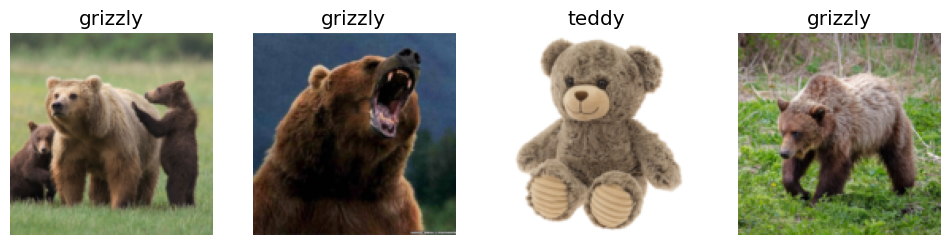

In [52]:
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

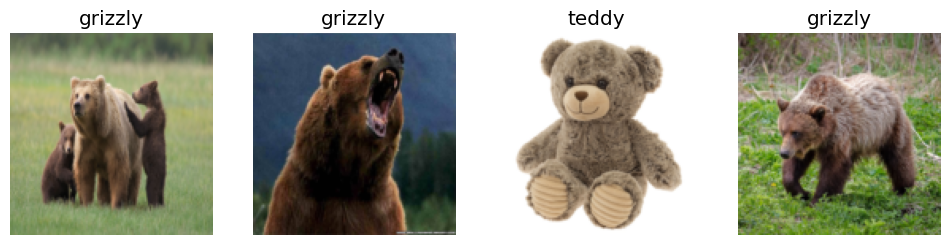

In [53]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

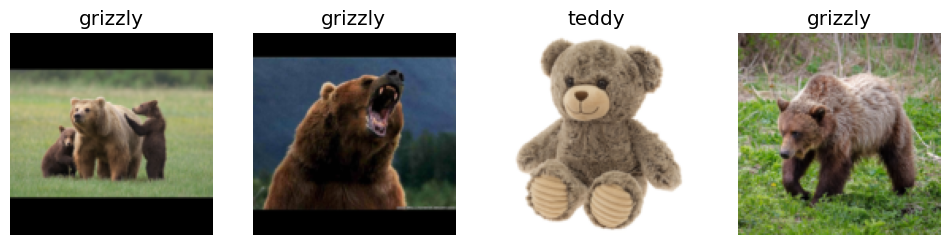

In [54]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

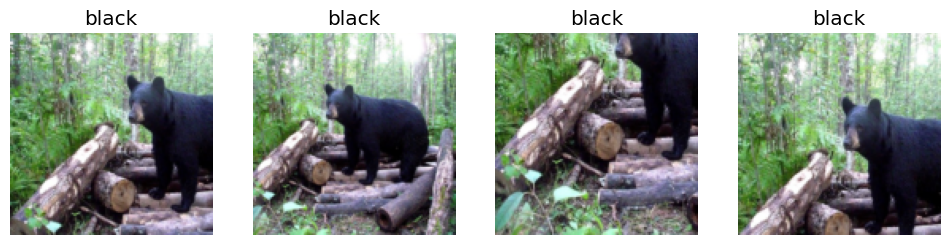

In [55]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

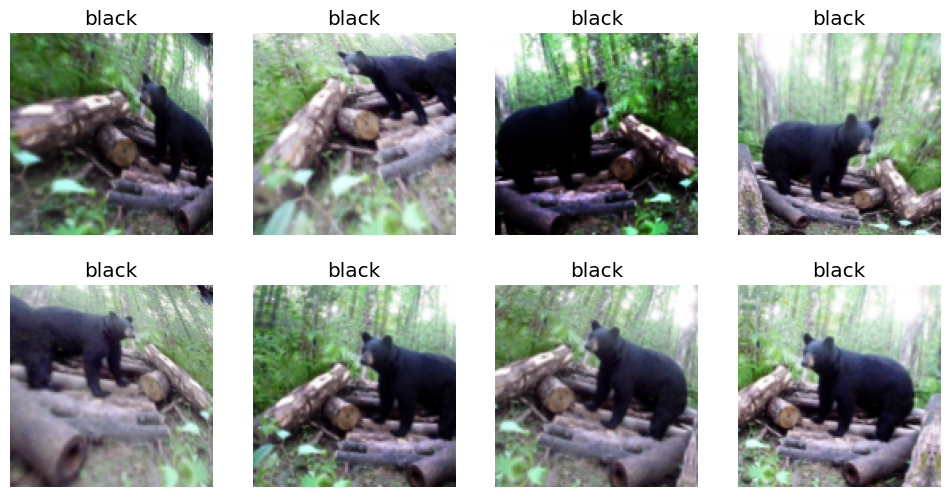

In [56]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

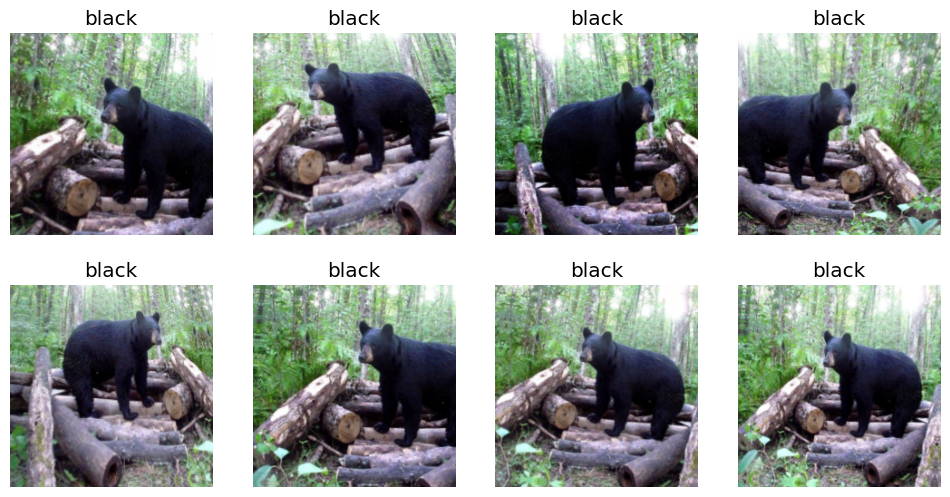

In [57]:
bears = bears.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),
                 batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [58]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.318529,0.121218,0.050633,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.215370,0.041469,0.025316,00:10
1,0.197700,0.018496,0.000000,00:10
2,0.157912,0.014223,0.000000,00:11
3,0.124918,0.011724,0.000000,00:10


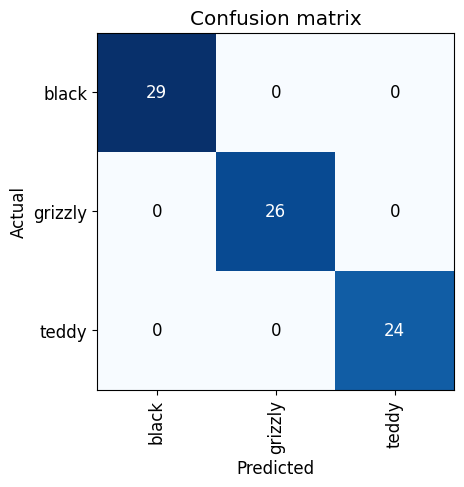

In [59]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

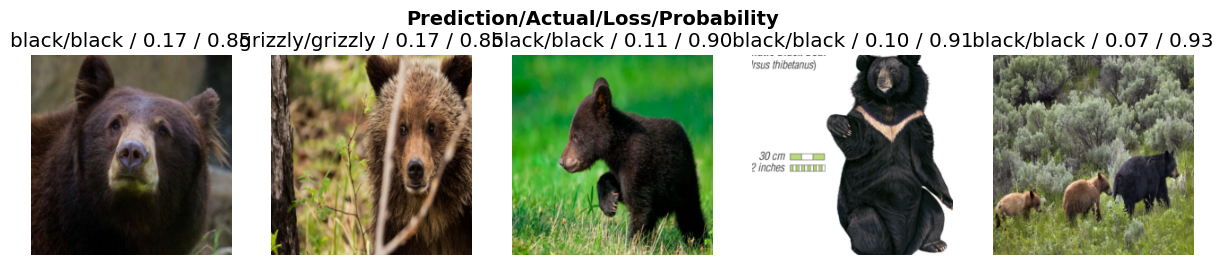

In [60]:
interp.plot_top_losses(5, nrows=1)

In [61]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [62]:
from pathlib import Path

for idx in cleaner.delete():
    file_path = cleaner.fns[idx]
    if file_path.exists():  # Ensure file exists
        file_path.unlink()
    else:
        print(f"File not found: {file_path}")


In [63]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [64]:
learn.export()

In [65]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [66]:
learn_inf = load_learner(path/'export.pkl')

In [67]:
ims = ['https://2.bp.blogspot.com/-NjMTuklENdE/UHzVv_8dIxI/AAAAAAAAA-U/tNBsQDn8kFI/s1600/Grizzly+Bear+Pic.jpg']

In [68]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

In [69]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([3.4283e-05, 9.9996e-01, 5.3147e-06]))

In [70]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [71]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [72]:
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [73]:
img = PILImage.create(btn_upload.data[-1])

In [74]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [75]:
pred,pred_idx,probs = learn_inf.predict(img)

In [76]:
lbl_pred = widgets.Label()
lbl_pred.value = f"Prediction: {pred}; Probability: {probs[pred_idx]:.04f}"
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

In [77]:
btn_run = widgets.Button(description="Classify")
btn_run

Button(description='Classify', style=ButtonStyle())

In [78]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_put: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f"Prediction: {pred}; Probability: {probs[pred_idx]:.04f}"

btn_run.on_click(on_click_classify)

In [79]:
btn_upload = widgets.FileUpload()

In [80]:
VBox([widgets.Label("Select your bear!"), 
      btn_upload, btn_run, out_pl, lbl_pred])